In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import joblib
import matplotlib.pyplot as plt

In [3]:
# Load and validate external dataset
try:
    df = pd.read_csv('Employee_Dataset.csv')
    expected_columns = ['Age', 'Experience', 'Education', 'Department', 'Location', 'Company Type', 'Performance Score', 'Last Hike %', 'Salary']
    if not all(col in df.columns for col in expected_columns):
        raise ValueError(f"Dataset must contain columns: {expected_columns}")
    print("Dataset loaded successfully")
    print(df.head())
except FileNotFoundError:
    print("Error: Employee_Dataset.csv not found. Please provide the dataset.")
    exit()
except ValueError as e:
    print(f"Error: {e}")
    exit()


Dataset loaded successfully
   Age  Experience   Education Department     Location Company Type  \
0   56          32    Master’s         HR     New York          MNC   
1   46          19    Master’s         HR  Los Angeles      Startup   
2   32          11  Bachelor’s         IT      Chicago      Startup   
3   60           0    Master’s      Sales  Los Angeles          MNC   
4   25           9    Master’s      Sales  Los Angeles      Startup   

   Performance Score  Last Hike %  Salary  
0                4.7         14.1  8611.0  
1                2.4          6.0  6563.0  
2                2.2          8.5  5176.0  
3                1.8          8.9  3577.0  
4                3.7          4.8  5542.0  


In [4]:
# Preprocess Data
selected_columns = ['Age', 'Experience', 'Education', 'Department', 'Location', 'Company Type', 'Performance Score', 'Last Hike %', 'Salary']
df = df[selected_columns]
numeric_features = ['Age', 'Experience', 'Performance Score', 'Last Hike %']
categorical_features = ['Education', 'Department', 'Location', 'Company Type']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', sparse_output=False))
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

X = df.drop('Salary', axis=1)
y = df['Salary']
X_preprocessed = preprocessor.fit_transform(X)
joblib.dump(preprocessor, 'preprocessor.pkl')
print('Preprocessor saved as preprocessor.pkl')


Preprocessor saved as preprocessor.pkl


In [5]:
# Train and Save Models
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

In [6]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
joblib.dump(lr, 'linear_regression_model.pkl')



['linear_regression_model.pkl']

In [7]:
# Random Forest with GridSearchCV
rf = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_
joblib.dump(best_rf, 'random_forest_model.pkl')



['random_forest_model.pkl']

In [9]:
# Deep Learning
dl_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(1)
])
dl_model.compile(optimizer='adam', loss='mse')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
dl_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=0)
dl_model.save('deep_learning_model.keras')
print('Models saved: linear_regression_model.pkl, random_forest_model.pkl, deep_learning_model.keras')

c:\Users\Nithish\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Models saved: linear_regression_model.pkl, random_forest_model.pkl, deep_learning_model.keras


In [13]:
# Evaluate Models
def evaluate_model(model, model_name, X_train, X_test, y_train, y_test):
    train_preds = model.predict(X_train) if model_name != 'Deep Learning' else model.predict(X_train, verbose=0).flatten()
    test_preds = model.predict(X_test) if model_name != 'Deep Learning' else model.predict(X_test, verbose=0).flatten()
    train_r2 = r2_score(y_train, train_preds)
    test_r2 = r2_score(y_test, test_preds)
    train_mse = mean_squared_error(y_train, train_preds)
    test_mse = mean_squared_error(y_test, test_preds)
    print(f'{model_name} - Training R²: {train_r2:.4f}, Test R²: {test_r2:.4f}')
    print(f'{model_name} - Training MSE: {train_mse:.2f}, Test MSE: {test_mse:.2f}')
    return test_r2, test_mse

lr_r2, lr_mse = evaluate_model(lr, 'Linear Regression', X_train, X_test, y_train, y_test)
rf_r2, rf_mse = evaluate_model(best_rf, 'Random Forest', X_train, X_test, y_train, y_test)
dl_r2, dl_mse = evaluate_model(dl_model, 'Deep Learning', X_train, X_test, y_train, y_test)

Linear Regression - Training R²: 0.9510, Test R²: 0.9467
Linear Regression - Training MSE: 81723.92, Test MSE: 87651.24
Random Forest - Training R²: 0.9812, Test R²: 0.9035
Random Forest - Training MSE: 31291.13, Test MSE: 158699.43
Deep Learning - Training R²: -17.6760, Test R²: -17.3902
Deep Learning - Training MSE: 31161486.39, Test MSE: 30231423.78


In [14]:
# Cross-validation
lr_cv_scores = cross_val_score(lr, X_preprocessed, y, cv=5, scoring='r2')
rf_cv_scores = cross_val_score(best_rf, X_preprocessed, y, cv=5, scoring='r2')
print(f'Linear Regression CV R²: {np.mean(lr_cv_scores):.4f} (±{np.std(lr_cv_scores):.4f})')
print(f'Random Forest CV R²: {np.mean(rf_cv_scores):.4f} (±{np.std(rf_cv_scores):.4f})')


Linear Regression CV R²: 0.9470 (±0.0074)
Random Forest CV R²: 0.9154 (±0.0121)


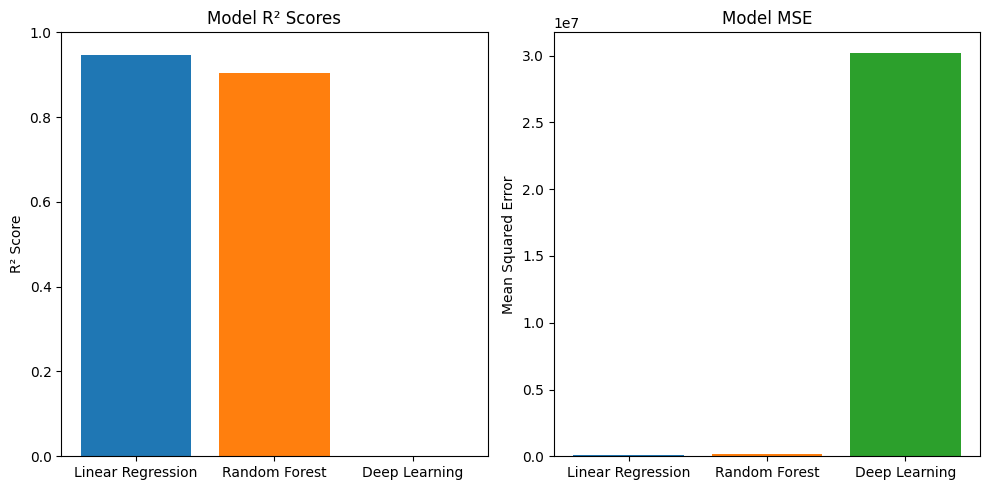

In [15]:
# Plot Model Performance
models = ['Linear Regression', 'Random Forest', 'Deep Learning']
r2_scores = [lr_r2, rf_r2, dl_r2]
mse_scores = [lr_mse, rf_mse, dl_mse]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(models, r2_scores, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.title('Model R² Scores')
plt.ylabel('R² Score')
plt.ylim(0, 1)

plt.subplot(1, 2, 2)
plt.bar(models, mse_scores, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.title('Model MSE')
plt.ylabel('Mean Squared Error')
plt.tight_layout()
plt.show()

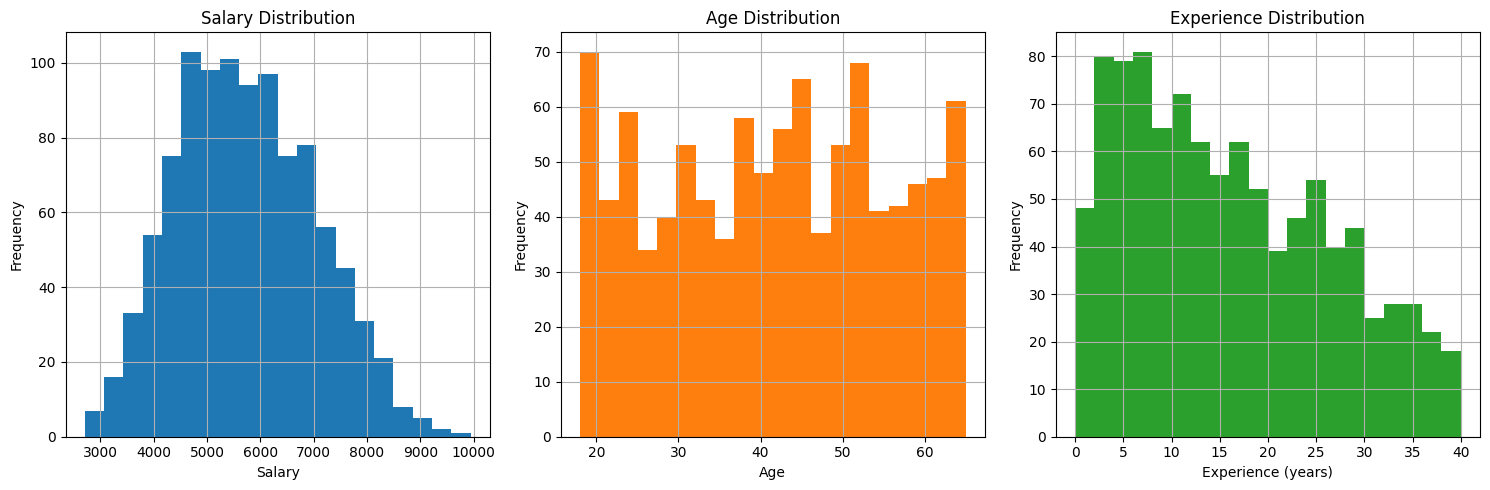

In [16]:
# Feature Distribution Plots
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
df['Salary'].hist(bins=20, color='#1f77b4')
plt.title('Salary Distribution')
plt.xlabel('Salary')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
df['Age'].hist(bins=20, color='#ff7f0e')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
df['Experience'].hist(bins=20, color='#2ca02c')
plt.title('Experience Distribution')
plt.xlabel('Experience (years)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()